In [1]:
import torch
use_gpu = False
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(f"Exécution sur {device}")

Exécution sur cpu


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
# Imports des bibliothèques utiles
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import ipywidgets as widgets
from IPython.display import display

from matplotlib import pyplot as plt
from tqdm import tqdm
import torchvision


In [4]:
torch.__version__

'2.6.0+cpu'

In [5]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST

from torchvision.transforms import ToTensor, ToPILImage



train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=ToTensor())

test_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=ToTensor())

In [7]:
# Définir les transformations pour normaliser les images
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Ajuste la taille des images
    transforms.ToTensor(),         # Convertit en tenseur PyTorch
    transforms.Normalize((0.5,), (0.5,))  # Normalisation (pour centrer les valeurs autour de 0)
])

# image_dir = "C:/Users/yetl1/Desktop/INSA/4BS/Dev_log/Data/img_align_celeba/img_align_celeba"
image_dir = "C:/Users/adele/Documents/4A local/S2/Projet_WEB/data_celebia/Img-20250407T213121Z-001/Img/img_align_celeba/img_align_celeba"

from torch.utils.data import Dataset
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None, max_images=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        if max_images:
            self.image_files = self.image_files[:max_images]  # Limiter le nombre d'images
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")  # Force RGB ici
        if self.transform:
            image = self.transform(image)
        return image


# Utilisation du dataset
# dataset = CustomImageDataset(image_dir, transform=transform, max_images=5000)
dataset = CustomImageDataset(image_dir, transform=transform, max_images=50000)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


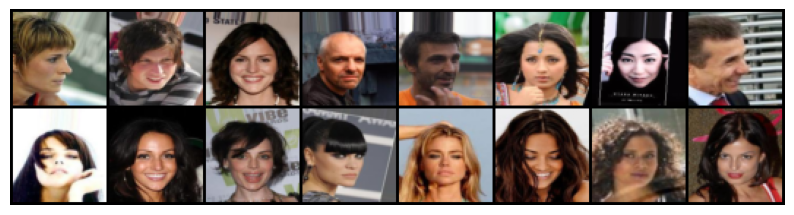

In [8]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Récupérer un batch d'images
images = next(iter(dataloader))

# Créer une grille d'images
grid_img = vutils.make_grid(images[:16], nrow=8, normalize=True)  # 16 images, 8 par ligne

# Afficher les images
plt.figure(figsize=(10, 5))
plt.imshow(grid_img.permute(1, 2, 0))  # Convertir (C, H, W) -> (H, W, C)
plt.axis("off")
plt.show()


In [9]:
size_lat = 5

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


latent_dimension = 512


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        
        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # (64x64) -> (32x32)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # (32x32) -> (16x16)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # (16x16) -> (8x8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),  # (8x8) -> (4x4)
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        # Décodeur
        self.fc_decode = nn.Linear(latent_dim, 256 * 4 * 4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # (4x4) -> (8x8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # (8x8) -> (16x16)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # (16x16) -> (32x32)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),  # (32x32) -> (64x64)
            nn.BatchNorm2d(3),
            nn.Sigmoid()  # Output entre 0 et 1
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # Reparametrization trick

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(x.size(0), 256, 4, 4)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [11]:
vae = VAE(latent_dimension)
# train_vae(vae, train_dataset)

In [12]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.l1_loss(recon_x, x, reduction='sum')  # Reconstruction Loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL Divergence
    return recon_loss + kl_loss


In [13]:
training = False

In [14]:
if training == True :
    
    num_epochs = 20
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for images in pbar:
            images = images.to(device)
            optimizer.zero_grad()

            recon_images, mu, logvar = vae(images)
            loss = loss_function(recon_images, images, mu, logvar)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / (pbar.n + 1)  # pbar.n est le nombre de batches traités

            pbar.set_description(f"Epoch {epoch+1}: loss = {avg_loss:.3f}")
    torch.save(vae.state_dict(), "vae_weights_5.pth")

else :
    vae.load_state_dict(torch.load("vae_weights_5.pth"))

vae.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (fc_mu): Linear(in_features=4096, out_features=512, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=512, bias=True)
  (fc_decode): Linear(in_features=512, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): Con

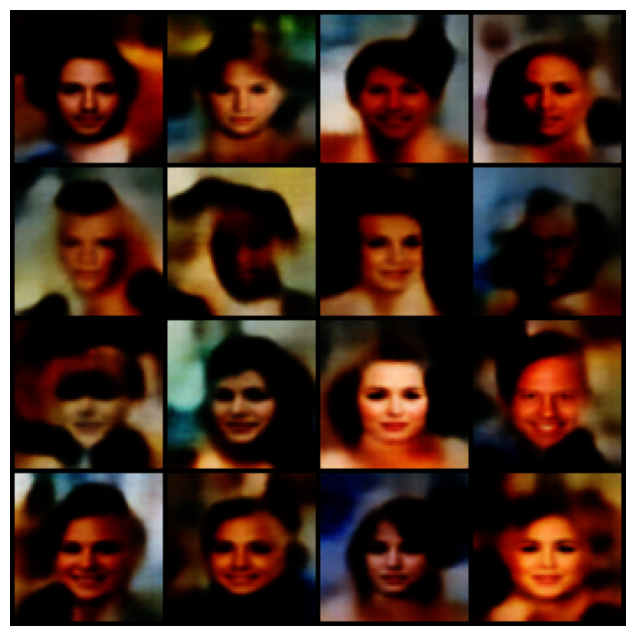

In [15]:

z = torch.randn(16, latent_dimension).to(device)  # 16 images
generated_images = vae.decode(z).cpu().detach()

# Affichage
grid = vutils.make_grid(generated_images, nrow=4, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()


train 0 : 30938.546 en 5:10

train 1 : 31000.084 en 4:00        avec 128 de latent_dim et 2 couches

train 2 : 30774.779 en 4:39        avec 128 de latent_dim et 3 couches

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


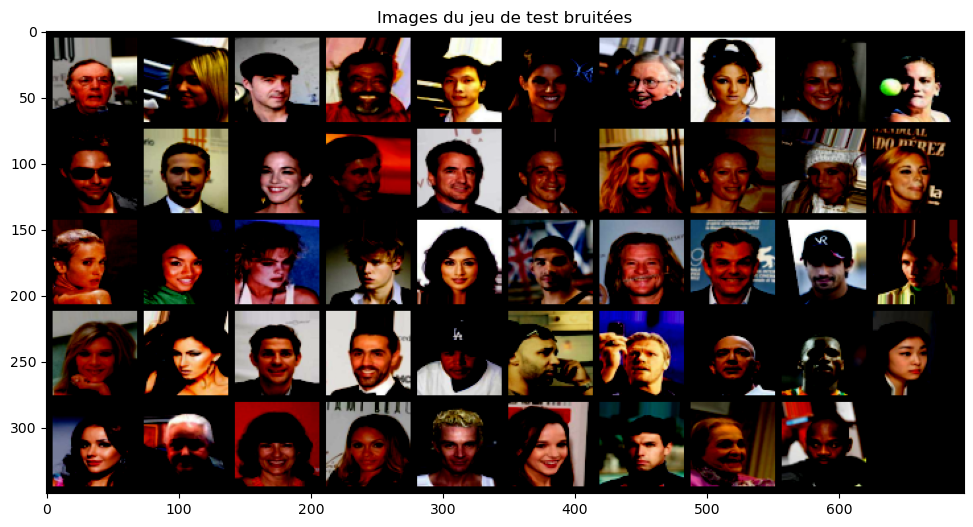

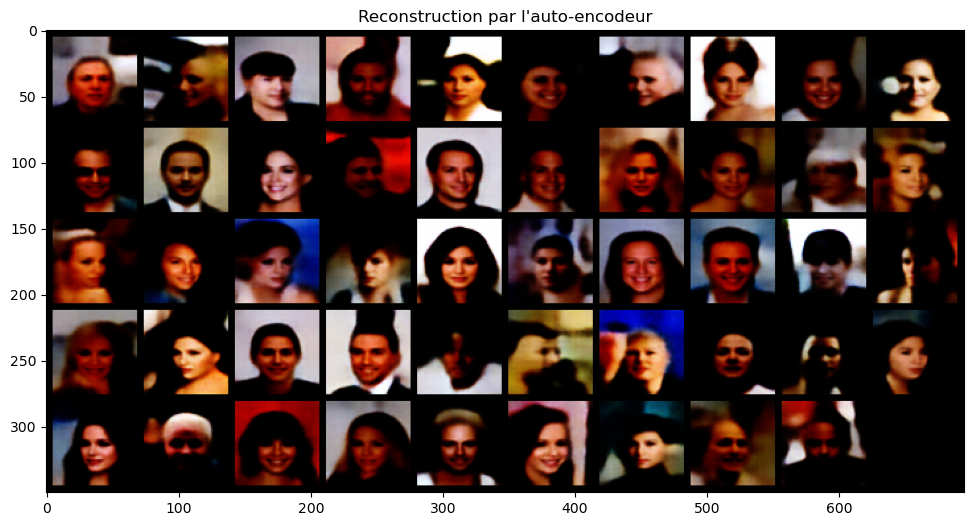

In [17]:
from torchvision.utils import make_grid

test_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


def show_grid(grid):
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

def visualize_reconstructions(net, images, device=device):
    # Mode inférence
    with torch.no_grad():
        images = images.to(device)
        reconstructions = net(images)[0]
        image_grid = make_grid(reconstructions[1:50], 10, 5).cpu()
        return image_grid




vae = vae.to("cpu")
images = next(iter(test_dataloader))

# Images de test
plt.figure(figsize=(12, 6))
plt.title("Images du jeu de test bruitées")
show_grid(make_grid(images[1:50],10,5))

# Reconstruction et visualisation des images reconstruites
plt.figure(figsize=(12, 6))
plt.title("Reconstruction par l'auto-encodeur")
show_grid(visualize_reconstructions(vae, images))

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Fonction pour extraire les codes latents
def extract_latent_codes(model, dataloader, device):
    model.eval()  # Mode évaluation
    latents = []
    
    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            
            
            mu, log_var = model.encode(images)  # VAE encode (mu, log_var)
            latent = mu.cpu().numpy()
                
            """
            print(len(latent))
            print(len(latent[0]))
            print(type(latent[0]))


            print(f"Type de latent: {type(latent)}")
            if isinstance(latent, torch.Tensor):
                print(f"Latent shape: {latent.shape}")
            elif isinstance(latent, tuple):
                print(f"Latent tuple length: {len(latent)}")
                for i, item in enumerate(latent):
                    print(f"Latent[{i}] shape: {item.shape if isinstance(item, torch.Tensor) else 'N/A'}")
            """
                
            latents.append(latent)
            
            
            """
                latent = model.encoder(images)  # Output direct de l'encodeur
                latent = latent.cpu().numpy()
                latents.append(latent.cpu().numpy())
            
            
            labels.append(targets.cpu().numpy())
            """
            

    latents = np.concatenate(latents, axis=0)
    
    
    
    
    return latents

# Appliquer t-SNE
def plot_latent_space(model, dataloader, device, title="Latent Space"):
    latents = extract_latent_codes(model, dataloader, device)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    
    """
    print(len(latents))
    print(latents[0])
    print(len(latents[0]))
    print(len(latents[0][1]))
    """
    
    latents_2d = tsne.fit_transform(latents)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], cmap="jet", alpha=0.7)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.show()

# Appel des fonctions avec ton modèle et test_dataloader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# plot_latent_space(vae, test_dataloader, device, title="VAE Latent Space")
# plot_latent_space(ae, test_dataloader, device, title="AE Latent Space")


In [19]:
def generate_random_images(model, latent_mean, latent_std, n=10):
    model.eval()
    with torch.no_grad():
        latent_samples = np.random.randn(n, latent_mean.shape[0]) * latent_std + latent_mean
        latent_samples = torch.tensor(latent_samples, dtype=torch.float32).to(device)
        generated = model.decode(latent_samples)
        return generated.cpu()

def show_generated_images(images, nrow=5):
    grid_img = torchvision.utils.make_grid(images, nrow=nrow, normalize=True)
    plt.figure(figsize=(15, 8))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    plt.show()


latents, labels = extract_latent_codes(vae, test_dataloader, device)

latent_mean = latents.mean(axis=0)
latent_var = latents.var(axis=0)
latent_std = np.sqrt(latent_var)

In [ ]:
latents = extract_latent_codes(vae, test_dataloader, device)

latent_mean = latents.mean(axis=0)
latent_std = latents.std(axis=0)

generated_images = generate_random_images(vae, latent_mean, latent_std, n=15)
show_generated_images(generated_images, nrow=5)


# ALGO GENETIQUE MA GUEULE

In [ ]:
import pandas as pd

# Chemin vers le CSV
ATTR_CSV_PATH = "C:/Users/adele/Documents/4A local/S2/Projet_WEB/list_attr_celeba.csv"

# Chargement du fichier CSV des attributs
attr_df = pd.read_csv(ATTR_CSV_PATH, index_col=0)

# Conversion des -1 en 0 pour que tout soit binaire
attr_df[attr_df == -1] = 0

# Exemple d'accès : attr_df.loc['202599.jpg']['Smiling']

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torchvision import transforms, utils as vutils
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# === Paramètres pour les attributs ===

ATTR_CSV = "C:/Users/adele/Documents/4A local/S2/Projet_WEB/list_attr_celeba.csv"  # Fichier CSV des attributs modifié avec les noms d'images corrigés
IMG_DIR = "C:/Users/adele/Documents/4A local/S2/Projet_WEB/data_celebia/Img-20250407T213121Z-001/Img/img_align_celeba/img_align_celeba"

# === Paramètres pour les autres traitements ===
NB_SAMPLES = 5000  # Nombre d'échantillons pour calculer les directions
IMG_SIZE = 64  # Taille de l'image après redimensionnement
attribute_directions = {}  # Dictionnaire pour stocker les directions des attributs

# === Paramètres d'entraînement et de génération ===
mutation_strength = 0.1  # Force de la mutation dans la génération
attribute_strength = 1.0  # Force du changement lors du forçage d'attributs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- 1. Nettoyer le CSV en enlevant l'extension .jpg -----
df = pd.read_csv(ATTR_CSV, sep=';')

# ----- 2. Encode les images sélectionnées -----
def get_latents_from_images(images, model, device):
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        mu, _ = model.encode(images)
        return mu.cpu().numpy()

# ----- 3. Génère 10 enfants par crossover + mutation -----
def generate_initial_population(parents_latents, n_children=10, mutation_strength=0.5):
    children = []
    for _ in range(n_children):
        p1, p2 = np.random.choice(len(parents_latents), 2, replace=True)
        alpha = np.random.rand()
        child = alpha * parents_latents[p1] + (1 - alpha) * parents_latents[p2]
        mutation = np.random.randn(*child.shape) * mutation_strength
        child += mutation
        children.append(child)
    return np.array(children)

# ----- 4. Decode les latents en images -----
def decode_latents_to_images(latents, model, device):
    model.eval()
    with torch.no_grad():
        latents = torch.tensor(latents, dtype=torch.float32).to(device)
        images = model.decode(latents)
        return images.cpu()

# ----- 5. Affichage des images -----
def show_images(images, title="Génération actuelle"):
    grid = vutils.make_grid(images, nrow=5, normalize=True)
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

# ----- 6. Sélection de l'utilisateur -----
def ask_user_selection(n=10):
    while True:
        selection = input(f"Quels visages sélectionnez-vous ? (1-{n}, 0=regénérer, 'undo'=retour) : ").strip()
        if selection.lower() == "undo":
            return "undo"
        elif selection == "0":
            return []
        else:
            try:
                indices = [int(x.strip()) - 1 for x in selection.split()]
                if all(0 <= idx < n for idx in indices) and len(indices) > 0:
                    return indices
                else:
                    print("❌ Indices invalides. Réessaye.")
            except ValueError:
                print("❌ Format invalide. Réessaye.")

# ----- 7. Force des attributs -----
def force_attributes_on_latents(children_latents, attr_list, attribute_strength=1.0):
    for i in range(len(children_latents)):
        for attr in attr_list:
            children_latents[i] += attribute_directions[attr] * attribute_strength
    return children_latents

# ----- 8. Calcul des directions des attributs depuis le CSV -----
def compute_attribute_directions_from_csv(model, device):
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ])
    
    print("🔄 Chargement et encodage des images CelebA pour calcul des attributs...")
    
    attr_df = pd.read_csv("C:/Users/adele/Documents/4A local/S2/Projet_WEB/list_attr_celeba.csv", sep=';', index_col=0)
    attr_names = list(attr_df.columns)
    selected_df = attr_df.sample(n=NB_SAMPLES, random_state=42)
    images, attrs = [], []
    
    for img_name, row in tqdm(selected_df.iterrows(), total=NB_SAMPLES):
        img_name_with_extension = img_name.strip()
        path = os.path.join(IMG_DIR, img_name_with_extension)
        
        if not os.path.exists(path):
            print(f"⚠️ L'image {img_name_with_extension} n'a pas été trouvée dans le dossier.")
            continue
        
        try:
            img = Image.open(path).convert("RGB")
            img = transform(img)
            images.append(img)
            attrs.append(row.values)
        except Exception as e:
            print(f"⚠️ Échec de chargement de l'image {img_name_with_extension} : {e}")
            continue
    
    if len(images) == 0:
        raise RuntimeError("Aucune image valide n'a été chargée.")
    
    images = torch.stack(images).to(device)
    
    with torch.no_grad():
        mu, _ = model.encode(images)
        latents = mu.cpu().numpy()
    
    attrs = np.array(attrs)
    
    return latents, attrs, attr_names

# ----- 9. Boucle évolutive manuelle -----
def genetic_manual_loop(initial_images, model, device, mutation_strength=0.1):
    global attribute_directions
    if len(attribute_directions) == 0:
        latents, attrs, attr_names = compute_attribute_directions_from_csv(model, device)

        attribute_directions = {}
        for i, attr in enumerate(attr_names):
            try:
                positive = latents[attrs[:, i] == 1]
                negative = latents[attrs[:, i] == -1]
                if len(positive) > 0 and len(negative) > 0:
                    direction = positive.mean(axis=0) - negative.mean(axis=0)
                    attribute_directions[attr] = direction
                else:
                    print(f"⚠️ Pas assez d'exemples pour l'attribut '{attr}', ignoré.")
            except Exception as e:
                print(f"⚠️ Erreur lors du calcul de la direction pour '{attr}' : {e}")
                continue
        
        print(f"✅ {len(attribute_directions)} directions d'attributs calculées.")

    parents_latents = get_latents_from_images(initial_images, model, device)
    history = [parents_latents.copy()]
    generation = 1

    while True:
        print(f"\n🔁 Génération {generation}")
        children_latents = generate_initial_population(parents_latents, mutation_strength=mutation_strength)
        children_images = decode_latents_to_images(children_latents, model, device)

        show_images(children_images, title=f"Génération {generation}")

        attr_input = input("\n📢 Veux-tu forcer des attributs sur la prochaine génération ?\n"
                           f"Liste dispo : {', '.join(list(attribute_directions.keys())[:10])}...\n"
                           "Entre des attributs séparés par un espace (ex: Smiling Male), ou ENTER pour rien : ").strip()

        attr_list = [attr for attr in attr_input.split() if attr in attribute_directions]
        if attr_input and not attr_list:
            print("⚠️ Certains attributs sont inconnus ou non supportés.")
        if attr_list:
            print(f"✨ Forçage des attributs : {', '.join(attr_list)}")
            children_latents = force_attributes_on_latents(children_latents, attr_list, attribute_strength)

        selection = ask_user_selection(n=10)

        if selection == "undo":
            if generation == 1:
                print("⚠️ Tu es déjà à la première génération, impossible de revenir en arrière.")
                continue
            history.pop()
            parents_latents = history[-1]
            generation -= 1
            print("↩️ Retour à la génération précédente.")
            continue

        elif selection == []:
            print("🔁 Nouvelle génération avec les mêmes parents...")
            continue

        else:
            parents_latents = children_latents[selection]
            history.append(parents_latents.copy())
            generation += 1

In [ ]:
genetic_manual_loop(images, vae, device)

## Visualiser attributs

In [ ]:
def visualize_attribute_directions(base_latents, model, device, attribute_directions, attribute_strength=3.0, attributes_to_test=None):
    if attributes_to_test is None:
        attributes_to_test = list(attribute_directions.keys())[:10]  # test les 10 premiers par défaut

    original_latent = base_latents[0].copy()  # on prend un latent comme base
    triplets = []

    for attr in attributes_to_test:
        direction = attribute_directions.get(attr)
        if direction is None:
            continue

        # version forcée en négatif / original / en positif
        negative = original_latent - attribute_strength * direction
        positive = original_latent + attribute_strength * direction

        latents_batch = np.stack([negative, original_latent, positive])
        images = decode_latents_to_images(latents_batch, model, device)
        triplets.append((attr, images))

    # Affichage
    n = len(triplets)
    fig, axes = plt.subplots(n, 3, figsize=(9, n * 2.5))
    for i, (attr, imgs) in enumerate(triplets):
        for j in range(3):
            ax = axes[i, j] if n > 1 else axes[j]
            ax.imshow(imgs[j].permute(1, 2, 0).clip(0, 1))
            ax.axis("off")
            if j == 1:
                ax.set_title(attr, fontsize=12)
            elif j == 0:
                ax.set_title("–", fontsize=10)
            else:
                ax.set_title("+", fontsize=10)

    plt.tight_layout()
    plt.show()

In [ ]:
parents_latents = get_latents_from_images(initial_images, model, device)
visualize_attribute_directions(parents_latents, model, device, attribute_directions, attribute_strength=3.0)